In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv('../data/FultonPUMS5full.csv')

In [125]:
df.sample(10)

,state,puma,sex,age,educ,income,latino,black,asian,married,divorced,uscitizen,children,disability,militaryservice,employed,englishability,fips
678,13,1101,1,35,14,58000.0,1,0,0,1,0,1,1,0,0,1,1,13121
24521,13,1107,0,42,7,40000.0,0,0,0,1,0,1,0,1,0,1,1,13121
8856,13,1102,0,82,10,9100.0,1,0,0,1,0,1,0,1,1,0,1,13121
4593,13,1102,0,49,15,90000.0,0,0,0,1,0,1,0,0,0,1,1,13121
16044,13,1104,1,56,9,24000.0,0,1,0,0,0,1,0,0,0,0,1,13121
19096,13,1105,0,70,15,3600.0,0,0,0,1,0,1,0,1,0,0,1,13121
23629,13,1107,1,79,9,4800.0,0,1,0,0,0,1,0,0,1,0,1,13121
9320,13,1103,0,26,13,45200.0,0,0,0,0,0,1,0,1,0,1,1,13121
19446,13,1105,0,29,11,24800.0,0,1,0,1,0,0,0,0,0,1,1,13121
2253,13,1101,1,39,13,1000.0,0,0,1,1,0,1,1,0,0,0,1,13121


Problem 1:

We need to find some subset of attributes such that their conjunction uniquely specifies an individual out of 100,000 other individuals in the same PUMA region.

In [126]:
attributes = ['age', 'income']
print("Using attributes {}".format(attributes))
for puma_index in df['puma'].unique():
    df_subset = df[df['puma'] == puma_index]
    attr_hash = np.apply_along_axis(
        func1d=lambda vec: hash('_'.join(vec.astype('str').tolist())), # hash the items
        axis=1, # in each row
        arr=df_subset[attributes].values, # matrix of relevant values
    )
    _, unique_counts = np.unique(attr_hash, return_counts=True)
    unique_individuals = unique_counts == 1
    uniquely_identified_ratio = unique_individuals.shape[0]/df_subset.shape[0]
    print("For PUMA block {},"
          " uniquely identified {:0.1f}% of individuals from a sample size of {}".format(
        puma_index, uniquely_identified_ratio*100, df_subset.shape[0]
    ))

Using attributes ['age', 'income']
For PUMA block 1101, uniquely identified 78.9% of individuals from a sample size of 3215
For PUMA block 1102, uniquely identified 72.9% of individuals from a sample size of 5736
For PUMA block 1103, uniquely identified 77.5% of individuals from a sample size of 3728
For PUMA block 1104, uniquely identified 68.4% of individuals from a sample size of 3740
For PUMA block 1105, uniquely identified 74.1% of individuals from a sample size of 3128
For PUMA block 1106, uniquely identified 76.7% of individuals from a sample size of 3236
For PUMA block 1107, uniquely identified 79.8% of individuals from a sample size of 2983


We can see that we can uniquely identify 90% of the individuals in a ~5% sample of each census block using only the 'age', 'education', and 'income' features.

However, we need to argue that even with 20x as many individuals, a sizable portion would still be uniquely identifiable.

So now, we'll make a less empirical approximation, namely that each feature is independent, and therefore that in the wider sample we'd get random samples from them.

In [613]:
attr_counts = {col:df[col].unique().shape[0] for col in df.columns if col!='puma'}
attrs_sorted = sorted(attr_counts.keys(), key=lambda x: attr_counts[x])
necessary_attrs = []
from operator import mul
while np.prod([1] + [attr_counts[a] for a in necessary_attrs]) < 100_000:
    print(np.prod([1] + [attr_counts[a] for a in necessary_attrs]))
    necessary_attrs.append(attrs_sorted.pop()) 
print(np.prod([1] + [attr_counts[a] for a in necessary_attrs]))
print("necessary: {}".format(necessary_attrs))
print("unused: {}".format(attrs_sorted))

1
71
3266
42458
84916
169832
necessary: ['income', 'age', 'educ', 'englishability', 'employed']
unused: ['state', 'fips', 'sex', 'latino', 'black', 'asian', 'married', 'divorced', 'uscitizen', 'children', 'disability', 'militaryservice']


Problem 2

In [248]:
df_original = pd.read_csv('../data/FultonPUMS5sample100.csv')
df = df_original

In [9]:
uscit = df['uscitizen']
df = df.drop(columns=['uscitizen'])

In [10]:
n = df.shape[0]
# we'll do a little work upfront to make hashing faster
df_stringified = np.array([''.join(row.values.astype('str')) for _, row in df.iterrows()])
def create_predicate_fn():
    hash_key = str(np.random.randint(10**10))
    return lambda x_stringified: hash(x_stringified + hash_key) % 2 == 0
    
def query(n_subsamples=False, rounding_R=False, noise_sigma=False):
    f = create_predicate_fn()
    included_inds = [f(row_str) for row_str in df_stringified]
    supposedly_included_inds = included_inds
    
    if n_subsamples: # compute using only a subset of the data
        good_inds = np.random.choice(range(n), n_subsamples, replace=False)
        included_in_subsample = np.zeros(n)
        included_in_subsample[good_inds] += 1
        included_inds *= included_in_subsample
    
    s = sum(uscit*included_inds) # compute the actual query
    
    if rounding_R: # round to the nearest multiple of R
        s = rounding_R*round(s/rounding_R)
    if noise_sigma: # add Gaussian noise with stdev noise_sigma
        s += np.random.normal(loc=0, scale=noise_sigma)
    if n_subsamples:
        s *= n/n_subsamples# scale back up
    return s, supposedly_included_inds

Now let's create the attack

In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False).fit(indices, answers)
estimated_uscit = lr.coef_

In [13]:
np.linalg.norm(estimated_uscit - uscit, ord=2)

2.498289336621914e-13

Let's demonstrate the effect of different secrecy mechanisms on our reconstruction attack.

Note that we'll assume that we will binarize our inferred attributes by rounding "uscitizen" to 0 or 1, even though our regression gives us out a continuous value.

In [14]:
def run_reconstruction_experiment(varied_param, n_trials_per=10, value_range=np.arange(1, n)):
    assert varied_param in ["n_subsamples", "rounding_R", "noise_sigma"]
    value_range = np.array(value_range)
    avg_mse = np.zeros(value_range.shape[0])
    avg_pct_correct = np.zeros(value_range.shape[0])

    from tqdm import tqdm
    for i, value in tqdm(enumerate(value_range), total=value_range.shape[0]):
        agg_mse = 0
        agg_pct_correct = 0
        for _ in range(n_trials_per):
            answers, indices = zip(*[query(
                **{varied_param:value}
            ) for _ in range(2*n)])
            estimated_uscit_raw = LinearRegression(fit_intercept=False).fit(indices, answers).coef_
            mse = np.linalg.norm(estimated_uscit_raw - uscit, ord=2)
            agg_mse += mse
            estimated_uscit = np.round(estimated_uscit_raw)
            agg_pct_correct += (uscit==estimated_uscit).mean()
        avg_mse[i] = agg_mse/n_trials_per
        avg_pct_correct[i] = agg_pct_correct/n_trials_per
    return avg_mse, avg_pct_correct

In [616]:
avg_mse_subsampling, avg_pc_subsampling = run_reconstruction_experiment(varied_param="n_subsamples")

100%|██████████| 99/99 [01:02<00:00,  1.59it/s]


In [121]:
avg_mse_subsampling_focused, avg_pc_subsampling_focused = run_reconstruction_experiment(
    varied_param="n_subsamples",
    value_range=np.arange(50, 80),
    n_trials_per=20
)

100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


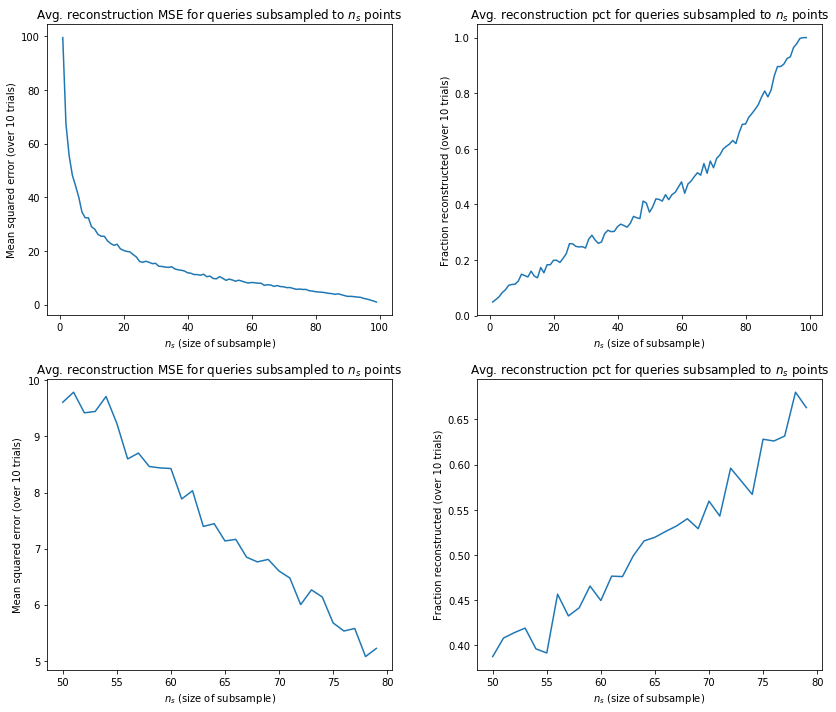

In [603]:
original_range = np.arange(1, n)
narrowed_range_subsampling = np.arange(50, 80)
plt.subplots(2, 2, figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_subsampling)
plt.title("Avg. reconstruction MSE for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_subsampling)
plt.title("Avg. reconstruction pct for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_subsampling, avg_mse_subsampling_focused)
plt.title("Avg. reconstruction MSE for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_subsampling, avg_pc_subsampling_focused)
plt.title("Avg. reconstruction pct for queries subsampled to $n_s$ points")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

It seems like reconstruction accuracy drops below 50% when using a subsample of less than 64 datapoints.

In [607]:
avg_mse_rounding,avg_pc_rounding = run_reconstruction_experiment(varied_param="rounding_R")

100%|██████████| 99/99 [00:55<00:00,  1.81it/s]


In [605]:
narrowed_range_rounding = np.arange(10, 20)
avg_mse_rounding_narrowed, avg_pc_rounding_narrowed = run_reconstruction_experiment(
    varied_param="rounding_R",
    value_range=narrowed_range_rounding,
    n_trials_per=20
)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


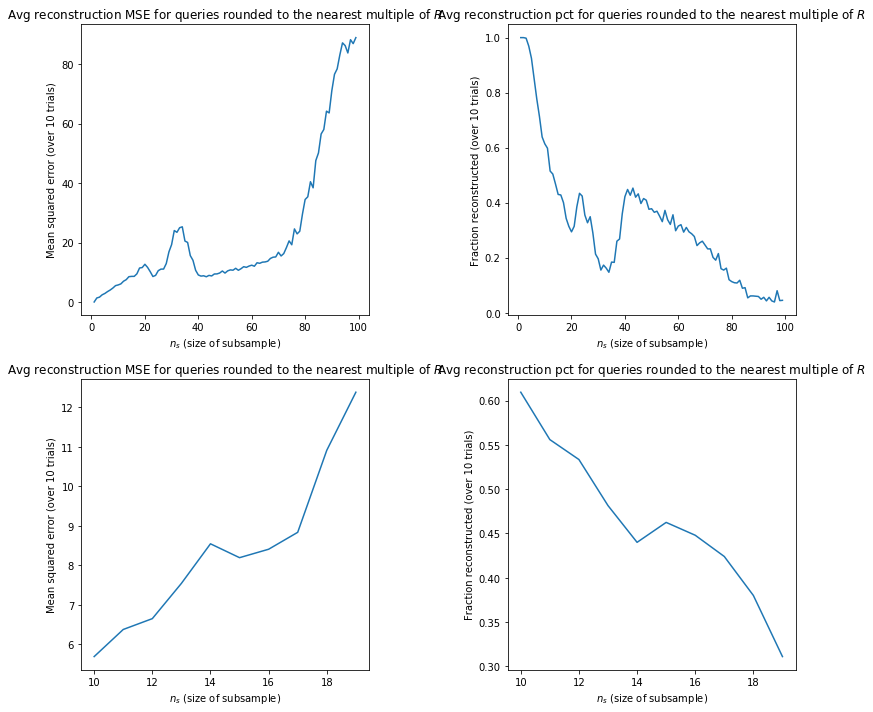

In [608]:
original_range = np.arange(1, n)
plt.subplots(2, 2, figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_rounding)
plt.title("Avg reconstr. MSE for queries rounded to nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_rounding)
plt.title("Avg reconstr. pct for queries rounded to nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_rounding, avg_mse_rounding_narrowed)
plt.title("Avg reconstr. MSE for queries rounded to nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_rounding, avg_pc_rounding_narrowed)
plt.title("Avg reconstr. pct for queries rounded to nearest multiple of $R$")
plt.xlabel("$n_s$ (size of subsample)")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

Rounding up to multiples of 12 seems to be the maximum tolerance for still reconstructing 50% of the data.

In [25]:
avg_mse_noise,avg_pc_noise = run_reconstruction_experiment(varied_param="noise_sigma")

100%|██████████| 99/99 [01:24<00:00,  1.18it/s]


In [29]:
narrowed_range_noise = np.linspace(0, 10, 50)
avg_mse_noise_narrowed, avg_pc_noise_narrowed = run_reconstruction_experiment(
    varied_param="noise_sigma",
    value_range=narrowed_range_noise,
    n_trials_per=20
)

100%|██████████| 50/50 [01:19<00:00,  1.55s/it]


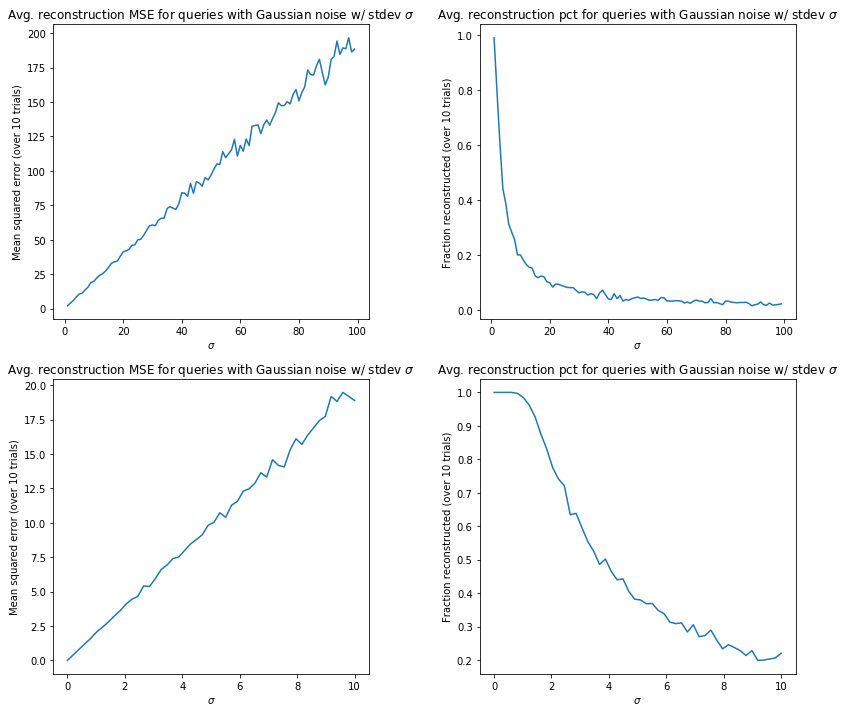

In [33]:
plt.subplots(2, 2, figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(original_range, avg_mse_noise)
plt.title("Avg. reconstruction MSE for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 2)
plt.plot(original_range, avg_pc_noise)
plt.title("Avg. reconstruction pct for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.subplot(2, 2, 3)
plt.plot(narrowed_range_noise, avg_mse_noise_narrowed)
plt.title("Avg. reconstruction MSE for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Mean squared error (over 10 trials)")
plt.subplot(2, 2, 4)
plt.plot(narrowed_range_noise, avg_pc_noise_narrowed)
plt.title("Avg. reconstruction pct for queries with Gaussian noise w/ stdev $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("Fraction reconstructed (over 10 trials)")
plt.tight_layout()

Reconstruction drops below 50% when injected Gaussian noise grows above $\sigma=4$.

Problem 3

We'll create a bunch of boolean predicates derived from the attributes (since we both don't have enough attributes and some of our attributes aren't boolean.)

Specifically, we'll construct 100 fake features.

In [588]:
max_constructed_features = 1000

df = df_original
df_stringified = np.array([''.join(row.values.astype('str')) for _, row in df.iterrows()])

new_predicate_fns = [create_predicate_fn() for _ in range(max_constructed_features)]
df_derived = pd.DataFrame()
for i, f in enumerate(new_predicate_fns):
    df_derived['np_{:03d}'.format(i)] = pd.Series([int(f(x)) for x in df_stringified])

In [589]:
df_full = pd.read_csv('../data/FultonPUMS5full.csv')
df_full_stringified = np.array([''.join(row.values.astype('str')) for _, row in df_full.iterrows()])
df_full_derived = pd.DataFrame()
for i, f in enumerate(new_predicate_fns):
    df_full_derived['np_{:03d}'.format(i)] = pd.Series([int(f(x)) for x in df_full_stringified])
rho_mean_maxd = df_full_derived.mean(axis=0).values

In [590]:
def sample_brn(rho_mean, n):
    return np.random.binomial(1, p=rho_mean, size=(n, rho_mean.shape[0]))

We aren't rescaling the values to be -1/1, and are instead sticking to 0/1.

In [591]:
def mean_query(a, n_subsamples=False, rounding_R=False, noise_sigma=False):
    n = a.shape[0]
    if n_subsamples: # compute using only a subset of the data
        good_inds = np.random.choice(range(n), n_subsamples, replace=False)
        included_in_subsample = np.zeros(n).astype(np.bool)
        included_in_subsample[good_inds] = True
        a = a[included_in_subsample]
    
    s = np.sum(a, axis=0, dtype=np.float64) # compute the actual query
    
    if rounding_R: # round to the nearest multiple of R
        s = rounding_R*np.round(s/rounding_R)
    if noise_sigma: # add Gaussian noise with stdev noise_sigma
        s += np.random.normal(loc=0, scale=noise_sigma, size=a.shape[1])
    if n_subsamples:
        s *= n/n_subsamples# scale back up
    return s/n

In [592]:
def membership_stat_dwork(x, rho_mean, a_mean):
    return np.sum((x-rho_mean)*(a_mean-rho_mean))

In [593]:
default_false_positive_rate = 1/(10*n)

null_sims = 10000
predrawn_binomials = [sample_brn(rho_mean_maxd, n) for _ in range(null_sims)]
def compute_T(rho_mean, mean_fun=lambda a: mean_query(a),
              n_sample=100, null_sims=null_sims, 
              false_positive_rate=default_false_positive_rate,
              use_predrawn_binomials=False
             ):
    null_stats = []
    for i in range(null_sims):
        if use_predrawn_binomials:
            null_distribution = predrawn_binomials[i][:, :rho_mean.shape[0]]
        else:
            null_distribution = sample_brn(rho_mean, n_sample)
        null_alice = sample_brn(rho_mean, 1)
        null_stat = membership_stat_dwork(null_alice, rho_mean, mean_fun(null_distribution))
        null_stats.append(null_stat)
    null_stats.sort(reverse=True)
    return null_stats[round(null_sims*false_positive_rate)], null_stats

Let's try out our attack!

In [ ]:
# Let's compute our method's true positive rate based on samples from our dataset
n_tp_trials = 10000
total_tps = 0
for _ in range(n_tp_trials): 
    x = a[np.random.choice(a.shape[0])]
    would_return_true = membership_stat_dwork(x, rho_mean, a.mean(axis=0)) > T
    total_tps += would_return_true
experimental_tpr = total_tps/n_tp_trials
print("Experimentally validated false-positive rate (for original dataset w/ 500 features): {}".format(experimental_tpr))

In [597]:
possible_ds = np.arange(20, 1000, 20)
n_tp_trials = 10000
query_funs = {}
query_funs['rounding'] = lambda a: mean_query(a, rounding_R=12)
query_funs['subsampling'] = lambda a: mean_query(a, n_subsamples=64)
query_funs['noise'] = lambda a: mean_query(a, noise_sigma=4)
defenses = {'rounding', 'subsampling', 'noise'}
Ts = {defense:[] for defense in defenses}
tprs = {defense:[] for defense in defenses}
for d in tqdm(possible_ds):
    a = df_derived.values[:, :d]
    rho_mean = rho_mean_maxd[:d]
    for defense in defenses:
        T, _ = compute_T(rho_mean, query_funs[defense], use_predrawn_binomials=True)
        Ts[defense].append(T)
        total_tps = 0
        for _ in range(n_tp_trials):
            x = a[np.random.choice(a.shape[0])]
            would_return_true = membership_stat_dwork(x, rho_mean, query_funs[defense](a)) > T
            total_tps += would_return_true
        experimental_tpr = total_tps/n_tp_trials
        tprs[defense].append(experimental_tpr)

100%|██████████| 49/49 [07:07<00:00, 12.14s/it]


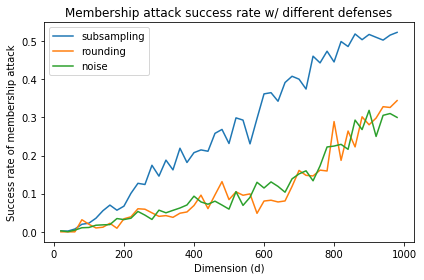

In [602]:
for defense in defenses:
    plt.plot(possible_ds, tprs[defense], label=defense)
plt.title("Membership attack success rate w/ different defenses")
plt.ylabel("Success rate of membership attack")
plt.xlabel("Dimension (d)")
plt.tight_layout()
plt.legend()